In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from final_project.data.data import load_data, summarise_data, date_cleaning, float_to_integer, add_missing_indicators, impute_council_from_suburb
from final_project.visualisations.visualisations import plot_histogram, plot_distribution, plot_boxplot, plot_grouped_boxplot, plot_value_counts, plot_kde_by_group, plot_barchart, plot_kde, plot_

# EDA Stage 1


### Raw Dataset 

In [2]:
df_raw = load_data()
print(df_raw.head())
print(df_raw.shape)


       Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
2  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   
3  4/03/2017       2.5    3067.0  ...       2.0  1.0      94.0           NaN   
4  4/06/2016       2.5    3067.0  ...       1.0  2.0     120.0         142.0   

   YearBuilt  CouncilArea Lattitude  Longtitude             Regionname  \
0     

### Summarising the Raw Dataset

In [3]:
summary = summarise_data(df_raw)
print(summary)


                 dtype  n_missing  pct_missing  n_unique           max  \
Address         object          0        0.000     13378           NaN   
Bathroom       float64          0        0.000         9  8.000000e+00   
Bedroom2       float64          0        0.000        12  2.000000e+01   
BuildingArea   float64       6450        0.475       602  4.451500e+04   
Car            float64         62        0.005        11  1.000000e+01   
CouncilArea     object       1369        0.101        33           NaN   
Date            object          0        0.000        58           NaN   
Distance       float64          0        0.000       202  4.810000e+01   
Landsize       float64          0        0.000      1448  4.330140e+05   
Lattitude      float64          0        0.000      6503 -3.740853e+01   
Longtitude     float64          0        0.000      7063  1.455264e+02   
Method          object          0        0.000         5           NaN   
Postcode       float64          0     

* dropping Address since it is a string identifier rather than a feature 
* dropping seller agent as it is highly cardinal and could cause overfitting 

In [4]:
df_raw = df_raw.drop(columns=["Address", "SellerG"])

### Converting Date column to datetime type

In [5]:
df_raw = date_cleaning(df_raw)
print(df_raw[["Year","Month","Day"]].head())
print(df_raw["Year"].unique())

   Year  Month  Day
0  2016     12    3
1  2016      2    4
2  2017      3    4
3  2017      3    4
4  2016      6    4
[2016 2017]


* Turning Year into binary feature (2016 is 0 and 2017 is 1) since there are only two years

In [6]:
df_raw["Year_binary"] = df_raw["Year"].map({2016: 0, 2017: 1})
df_raw = df_raw.drop(columns=["Year"])
print(df_raw[["Year_binary","Month","Day"]].head())
df_raw = df_raw.drop(columns=["Date"])

   Year_binary  Month  Day
0            0     12    3
1            0      2    4
2            1      3    4
3            1      3    4
4            0      6    4


### Correcting Data Types (Postcode and Build Year)

In [7]:
df_raw = float_to_integer(df_raw, "Postcode")
df_raw = float_to_integer(df_raw, "YearBuilt")
print(df_raw[["Postcode","YearBuilt"]].dtypes)

Postcode     Int64
YearBuilt    Int64
dtype: object


### Analysing the distribution of the target variable: Prices

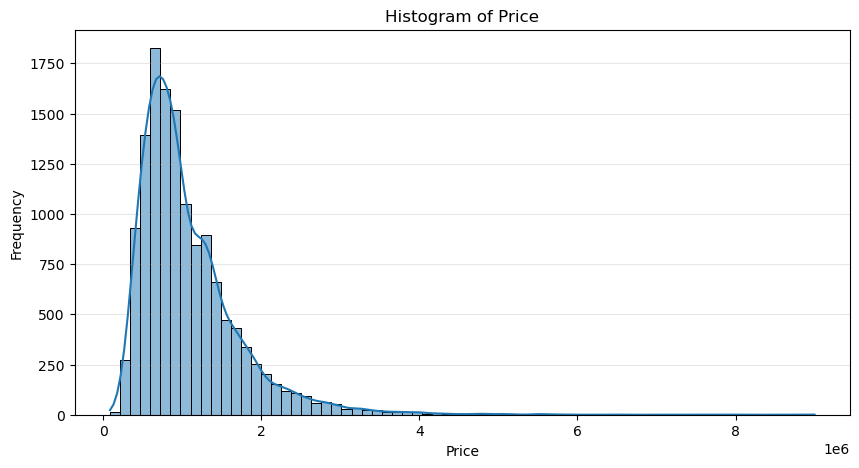

In [8]:
plot_histogram(df_raw,"Price", bins=70)

* Price is right skewed (which is expected for house price data) so a log transformation on Price could make it more normal 

2025-12-12 15:10:34.665 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.0)
2025-12-12 15:10:34.673 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.0)
2025-12-12 15:10:34.832 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted fisk distribution with error=0.0)
2025-12-12 15:10:34.994 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted burr distribution with error=0.0)


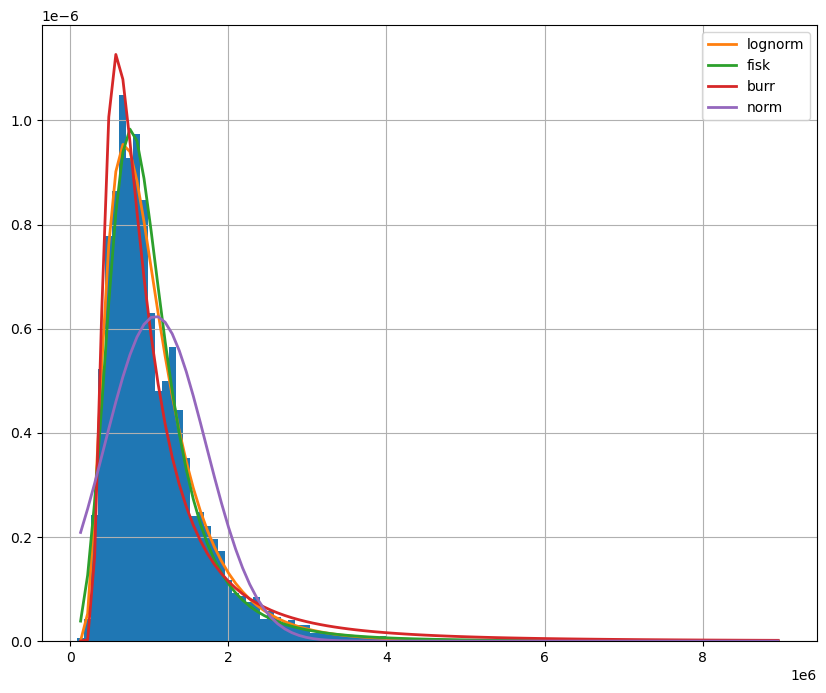

In [9]:
plot_distribution(df_raw, "Price", dist = ["fisk", "burr", "lognorm", "norm"])

* log normal and fisk distribution have the best fit 

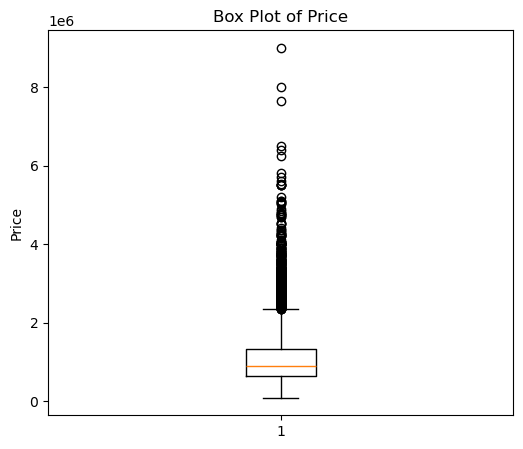

In [10]:
plot_boxplot(df_raw, "Price")

* boxplot shows outliers above the upper whisker which is expected as histogram shows a right skew. Logging price will reduce the right skew and there will be fewer outliers 

In [11]:
df_raw_logged = df_raw.copy()
df_raw_logged["Price"] = np.log(df_raw_logged["Price"])
df_raw_logged = df_raw_logged.rename(columns={"Price": "log_Price"})


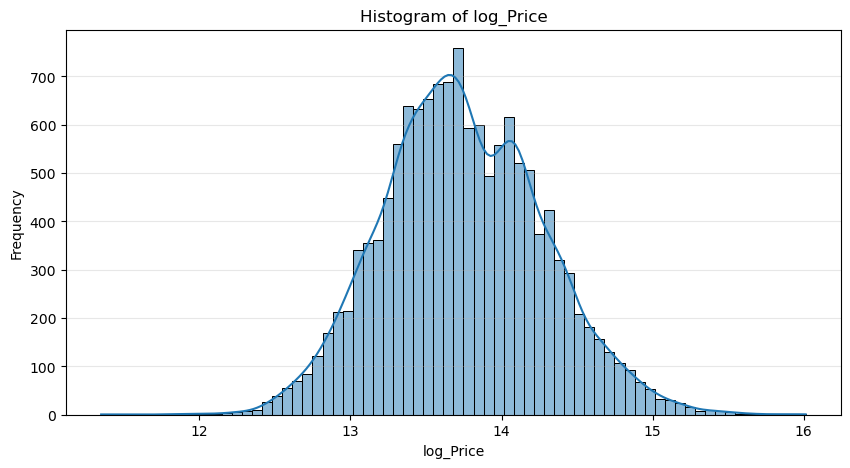

In [12]:
plot_histogram(df_raw_logged,"log_Price", bins=70)

* Price is now more normally distributed

2025-12-12 15:10:35.429 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.254584)
2025-12-12 15:10:35.751 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted burr distribution with error=0.291877)
2025-12-12 15:10:36.630 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted fisk distribution with error=0.328304)


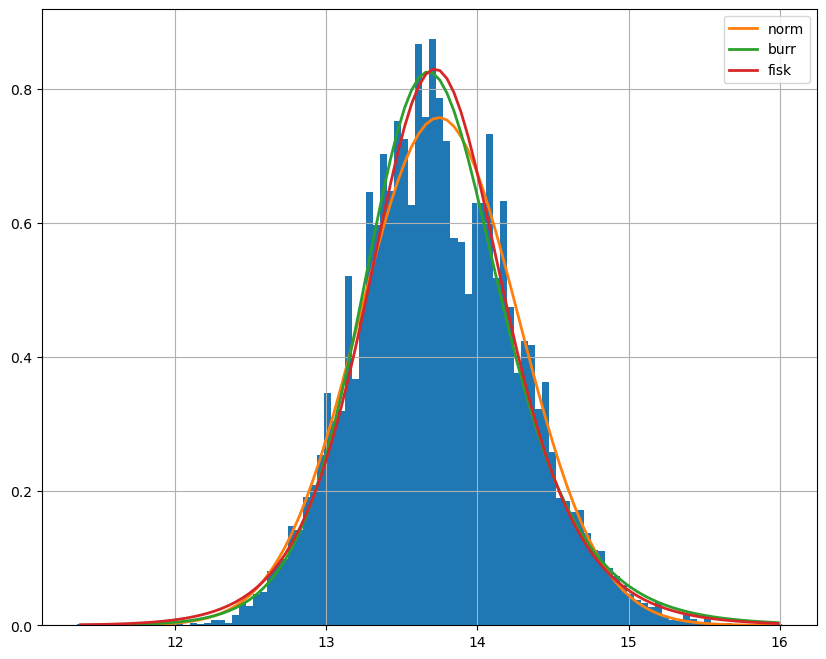

In [13]:
plot_distribution(df_raw_logged, "log_Price", dist = ["fisk", "burr", "norm"])

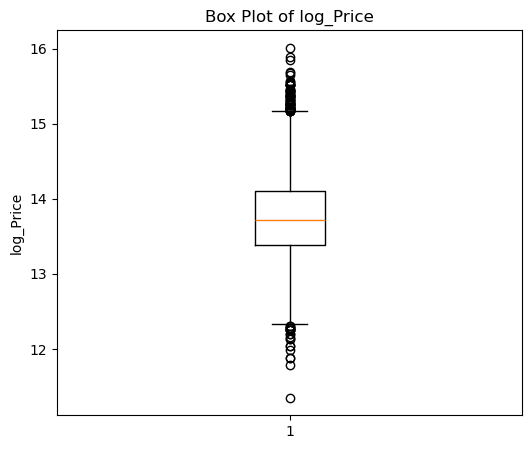

In [14]:
plot_boxplot(df_raw_logged, "log_Price")

* Price is now more symmetrically distributed. Hence, a log transformation of Price will be applied 

### EDA of features: Date (Year, Month, Day)

* Analysing if there is variation in hosue prices by Day and Month 

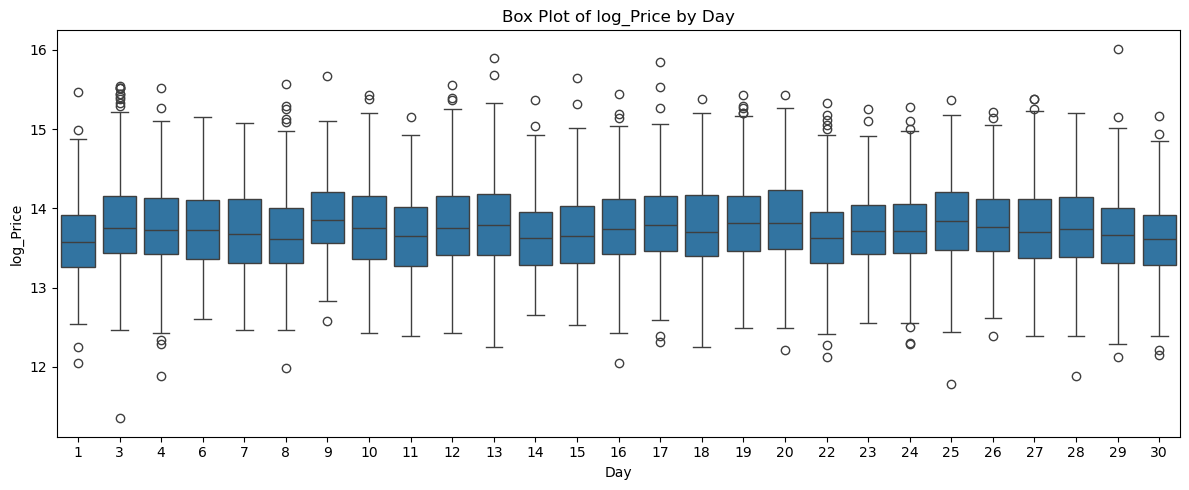

In [15]:
plot_grouped_boxplot(df_raw_logged, "Day", "log_Price")

* Dropping Day since distribution is very similar across days of the month with no trend

In [16]:
df_raw_logged = df_raw_logged.drop(columns=["Day"])

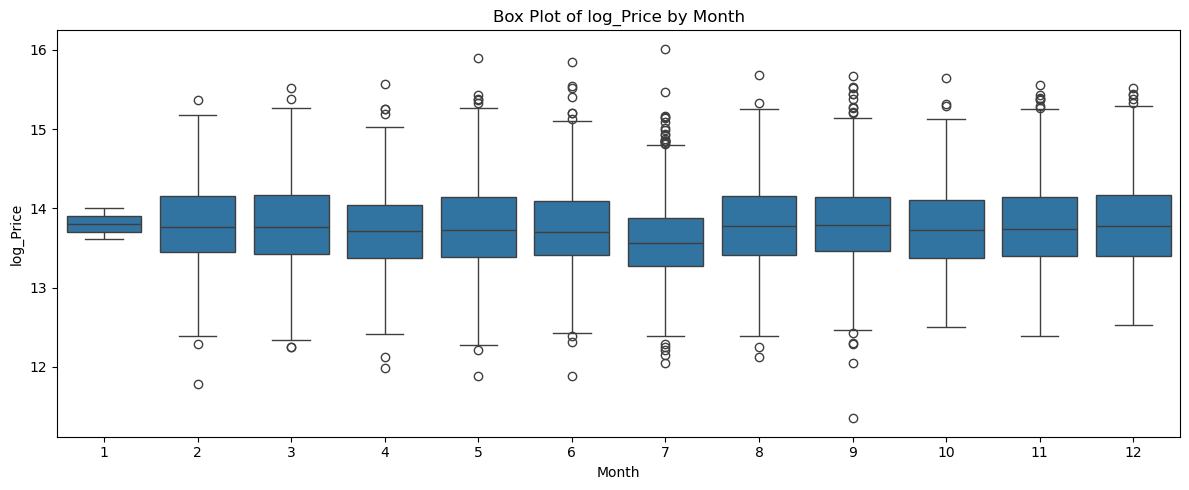

In [17]:
plot_grouped_boxplot(df_raw_logged, "Month", "log_Price")

* Dropping month since dataset is only 2 years and median log(price) is similar for all months

In [18]:
df_raw_logged = df_raw_logged.drop(columns=["Month"])

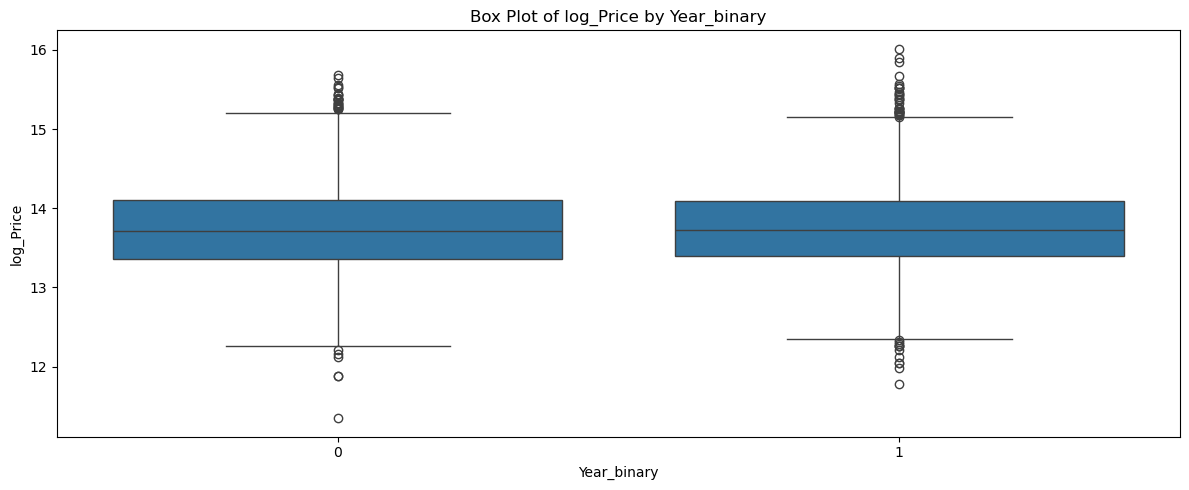

Year_binary
0    13.71015
1    13.72120
Name: log_Price, dtype: float64

In [19]:
plot_grouped_boxplot(df_raw_logged, "Year_binary", "log_Price")
df_raw_logged.groupby("Year_binary")["log_Price"].median()

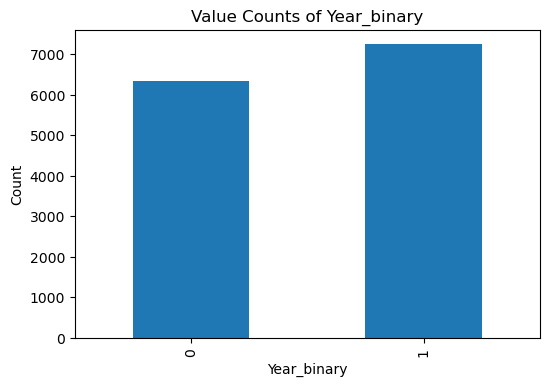

In [20]:
plot_value_counts(df_raw_logged, "Year_binary") 


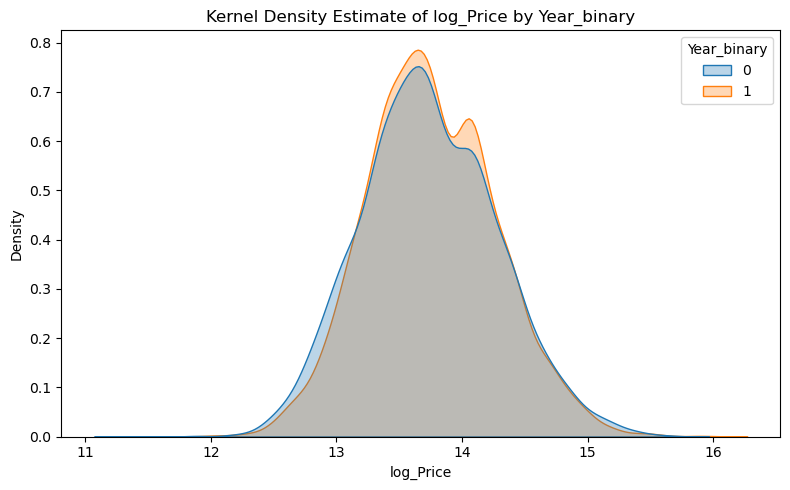

In [21]:
plot_kde_by_group(df_raw_logged, "log_Price", "Year_binary")

* The distribution of log prices by year is very similar and there are a considerable number of houses sold in both years. Hence, there is little time trend over 2016-2017 in house prices. 
* However, year will not be dropped as it is the only feature encoding macroecononomic factors such as economic growth, inflation and consumer confidence 

In [22]:
print(df_raw_logged.head())

       Suburb  Rooms Type  log_Price Method  Distance  Postcode  Bedroom2  \
0  Abbotsford      2    h  14.207553      S       2.5      3067       2.0   
1  Abbotsford      2    h  13.849912      S       2.5      3067       2.0   
2  Abbotsford      3    h  14.197366     SP       2.5      3067       3.0   
3  Abbotsford      3    h  13.652992     PI       2.5      3067       3.0   
4  Abbotsford      4    h  14.285514     VB       2.5      3067       3.0   

   Bathroom  Car  Landsize  BuildingArea  YearBuilt CouncilArea  Lattitude  \
0       1.0  1.0     202.0           NaN       <NA>       Yarra   -37.7996   
1       1.0  0.0     156.0          79.0       1900       Yarra   -37.8079   
2       2.0  0.0     134.0         150.0       1900       Yarra   -37.8093   
3       2.0  1.0      94.0           NaN       <NA>       Yarra   -37.7969   
4       1.0  2.0     120.0         142.0       2014       Yarra   -37.8072   

   Longtitude             Regionname  Propertycount  Year_binary  
0

In [23]:
summary = summarise_data(df_raw_logged)
print(summary)

                 dtype  n_missing  pct_missing  n_unique        max  \
Bathroom       float64          0        0.000         9        8.0   
Bedroom2       float64          0        0.000        12       20.0   
BuildingArea   float64       6450        0.475       602    44515.0   
Car            float64         62        0.005        11       10.0   
CouncilArea     object       1369        0.101        33       <NA>   
Distance       float64          0        0.000       202       48.1   
Landsize       float64          0        0.000      1448   433014.0   
Lattitude      float64          0        0.000      6503  -37.40853   
Longtitude     float64          0        0.000      7063  145.52635   
Method          object          0        0.000         5       <NA>   
Postcode         Int64          0        0.000       198     3977.0   
Propertycount  float64          0        0.000       311    21650.0   
Regionname      object          0        0.000         8       <NA>   
Rooms 

### Missing Data- Adding Missing Data Indicator

In [24]:
df_raw_logged = add_missing_indicators(df_raw_logged)
print(df_raw_logged.head())

       Suburb  Rooms Type  log_Price Method  Distance  Postcode  Bedroom2  \
0  Abbotsford      2    h  14.207553      S       2.5      3067       2.0   
1  Abbotsford      2    h  13.849912      S       2.5      3067       2.0   
2  Abbotsford      3    h  14.197366     SP       2.5      3067       3.0   
3  Abbotsford      3    h  13.652992     PI       2.5      3067       3.0   
4  Abbotsford      4    h  14.285514     VB       2.5      3067       3.0   

   Bathroom  Car  ...  CouncilArea  Lattitude  Longtitude  \
0       1.0  1.0  ...        Yarra   -37.7996    144.9984   
1       1.0  0.0  ...        Yarra   -37.8079    144.9934   
2       2.0  0.0  ...        Yarra   -37.8093    144.9944   
3       2.0  1.0  ...        Yarra   -37.7969    144.9969   
4       1.0  2.0  ...        Yarra   -37.8072    144.9941   

              Regionname  Propertycount  Year_binary Missing_Car  \
0  Northern Metropolitan         4019.0            0           0   
1  Northern Metropolitan         4

### Missing Data- Building Area

* 47% of data for Building Area is missing. Inspecting if this is random or systematic (e.g. less expensive houses less likely to report building area)

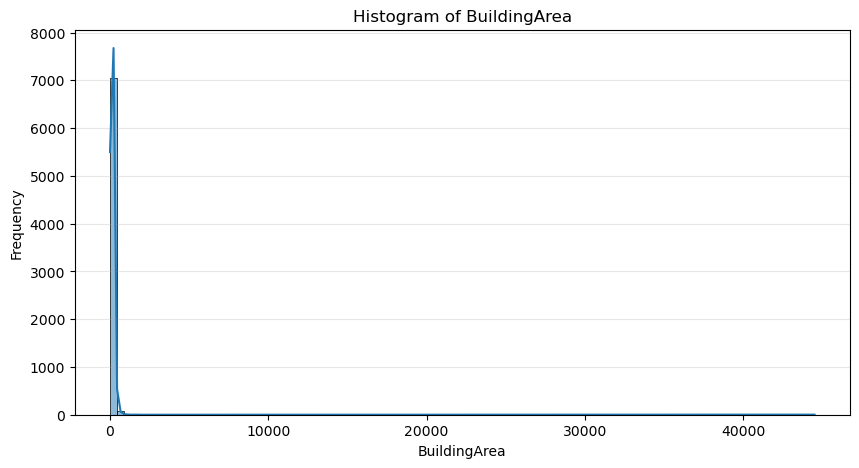

In [25]:
plot_histogram(df_raw_logged, "BuildingArea", bins=100)

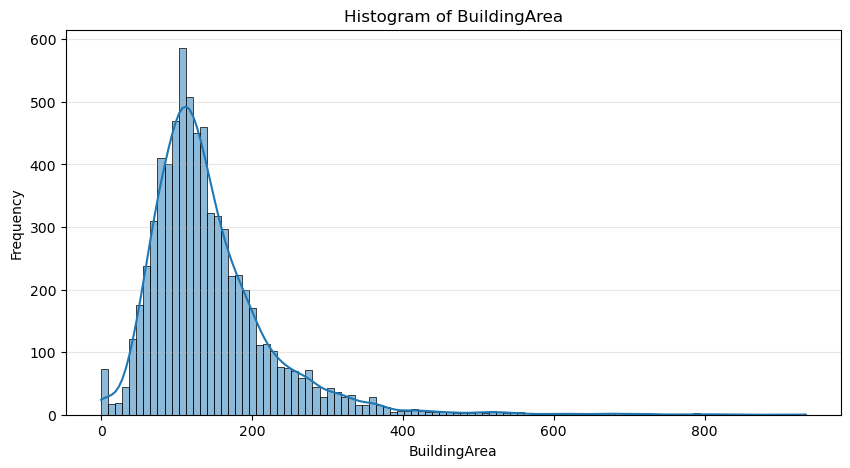

In [26]:
plot_histogram(df_raw_logged[df_raw_logged["BuildingArea"] < 1000], "BuildingArea", bins=100)




* Most houses with reported Building Areas have Building area between 50m^2 and 300m^2 and there is a very long tail to 40,000+


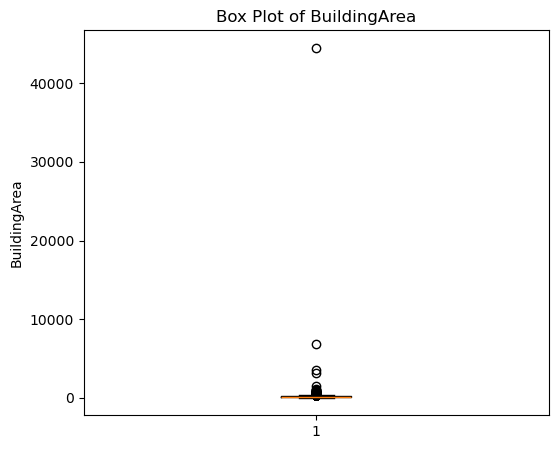

In [27]:
plot_boxplot(df_raw_logged, "BuildingArea")

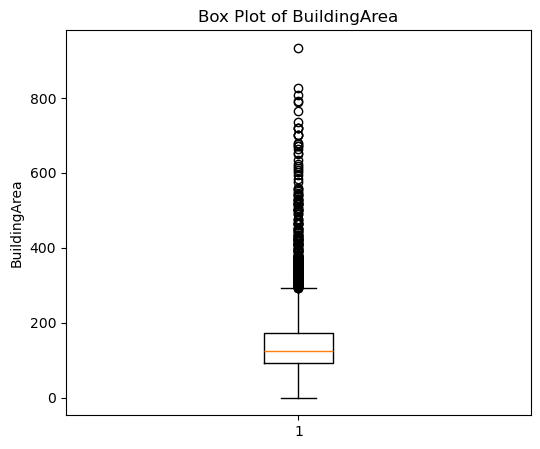

In [28]:
plot_boxplot(df_raw_logged[df_raw_logged["BuildingArea"] < 1000], "BuildingArea")

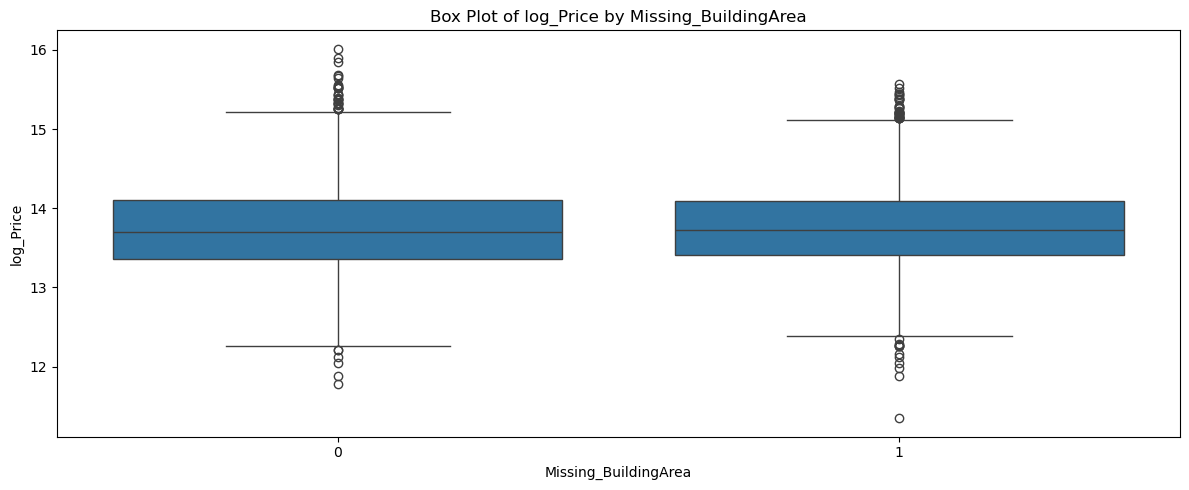

In [29]:
plot_grouped_boxplot(df_raw_logged, "Missing_BuildingArea", "log_Price")

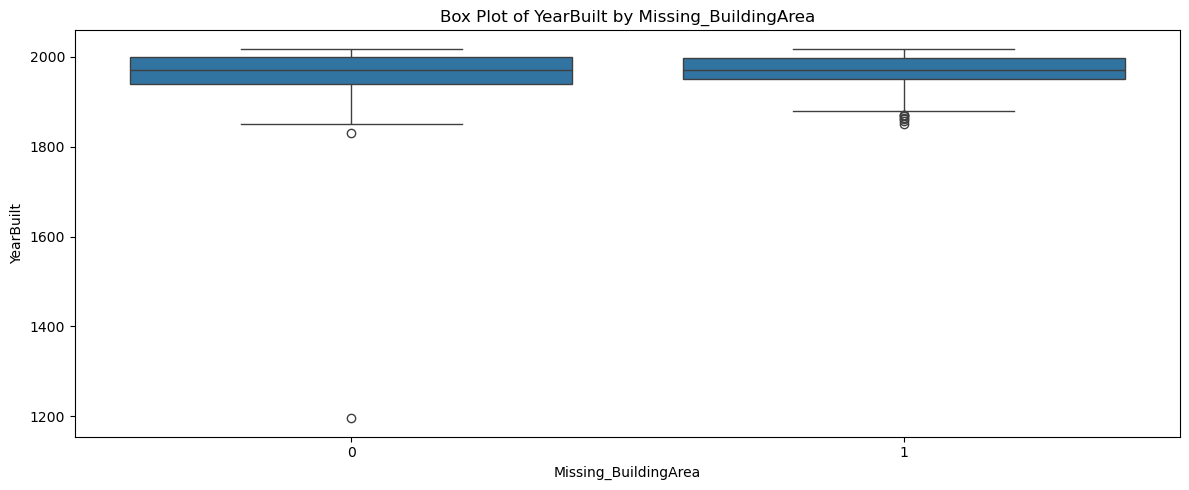

In [30]:
plot_grouped_boxplot(df_raw_logged, "Missing_BuildingArea", "YearBuilt")

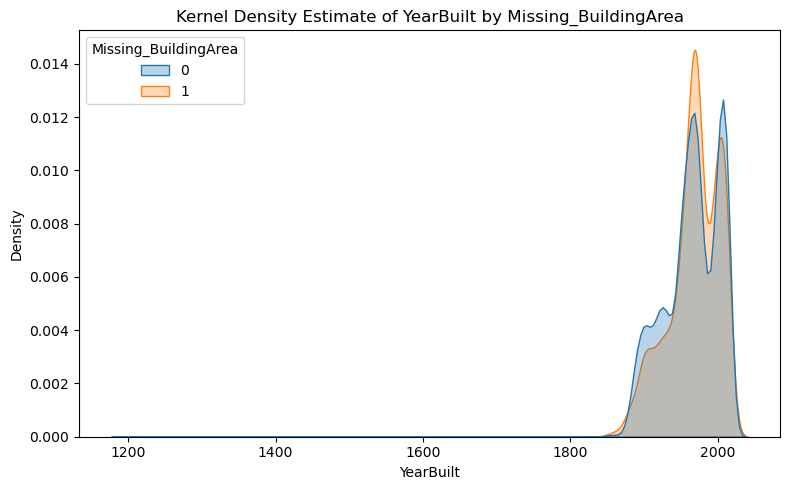

In [31]:
plot_kde_by_group(df_raw_logged, "YearBuilt", "Missing_BuildingArea")


* Although missing Building Area is not strongly related to price (since missing and non missing observations have similar distributions), it is related to the Year built. Older homes are more likely to have building sizes. However, year built also faces significant missing data, hence imputing Building size missing data based on year built is difficult
* Since 47% of observations are missing and the missingness is non-random, building area will be dropped
* Also, Landsize is likely to contain similar information to Building size

In [32]:
df_raw_logged = df_raw_logged.drop(columns=["BuildingArea"])

### Missing Data- Council 

* In Melbourne, each suburb belongs to a single council. Hence, if there is missing data for a council, it can be imputed from the suburb the observation belongs to.
* Council/ Suburb may be dropped later as many suburbs are a subset of one council but we can impute the missing data for council 

In [33]:
df_raw_logged = impute_council_from_suburb(df_raw_logged)
print(df_raw_logged["CouncilArea"].eq("Unavailable").sum())

8


* There are now only 8 obsverations with Council Area missing since the Suburb does not map to a known Council Area. These are labelled as "Unavailable"

### Missing Data- Car

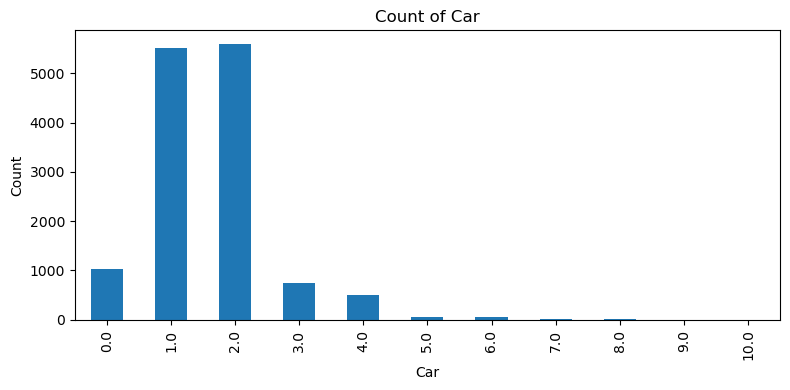

In [34]:
plot_barchart(df_raw_logged, "Car")

* There is small number of missing values (62 values, 0.05% of the observations) and the data is slightly right skewed, median imputation for Car later in the pipeline is suitable 

### Missing Data- Year Built 

* Binning years into decades due to high level of cardinality in dataset

In [35]:
df_raw_logged["YearBuilt_decade"] = (df_raw_logged["YearBuilt"] // 10) * 10


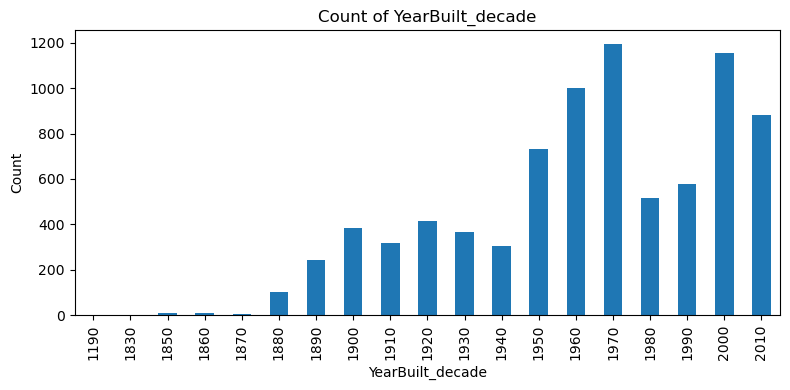

In [36]:
plot_barchart(df_raw_logged, "YearBuilt_decade")


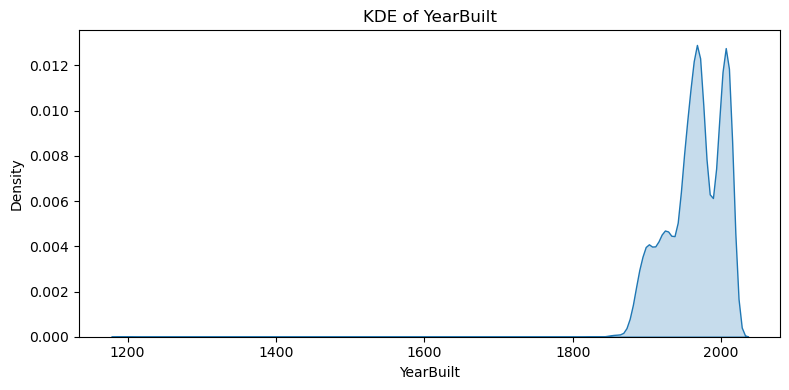

In [37]:
plot_kde(df_raw_logged, "YearBuilt")

* Year Built is multi-modal and is not normally distributed hence mean imputation is not suitable 
* Will check to see if there is systematic nature of missing data by seeing if missing data is associated with Price 
* Will also check to see if Year Built is heterogeneous across locations

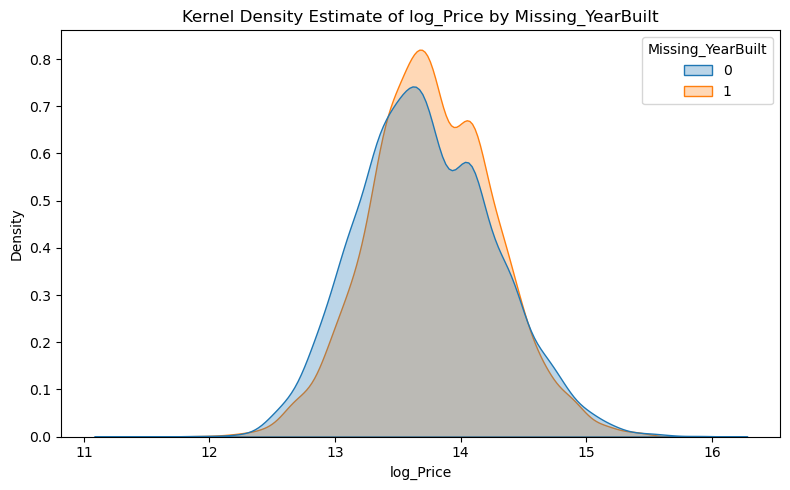

In [38]:
plot_kde_by_group(df_raw_logged, "log_Price", "Missing_YearBuilt")

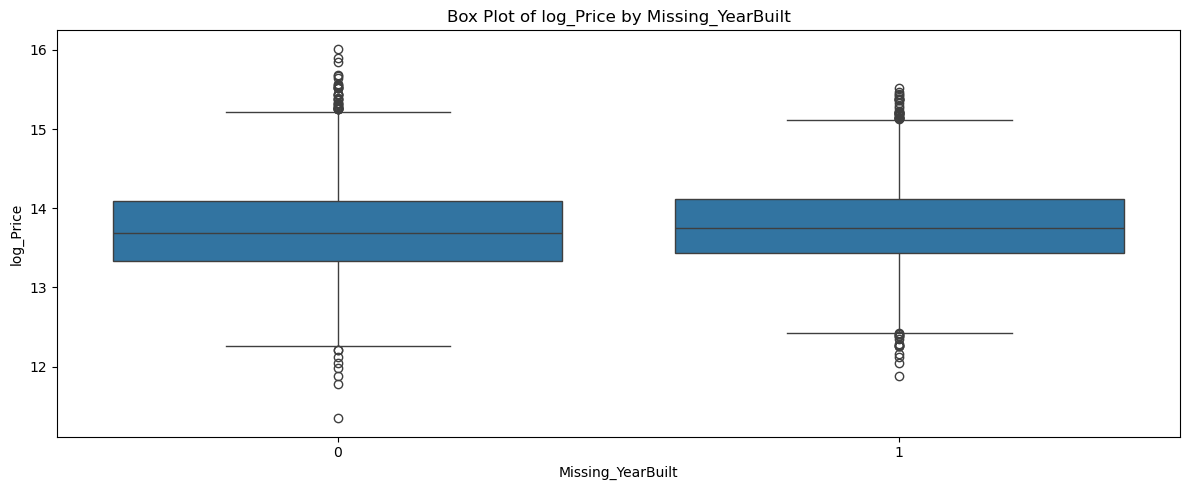

In [39]:
plot_grouped_boxplot(df_raw_logged, "Missing_YearBuilt", "log_Price")

* Missing Years are associated with higher property prices- hence missing years is not random. This could be since houses with missing year builds are older properties.

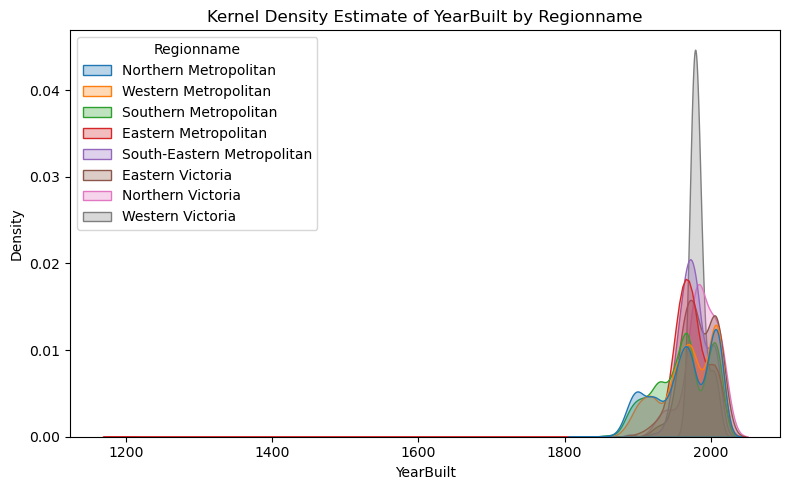

In [40]:
plot_kde_by_group(df_raw_logged, "YearBuilt", "Regionname")

<Figure size 1200x800 with 0 Axes>

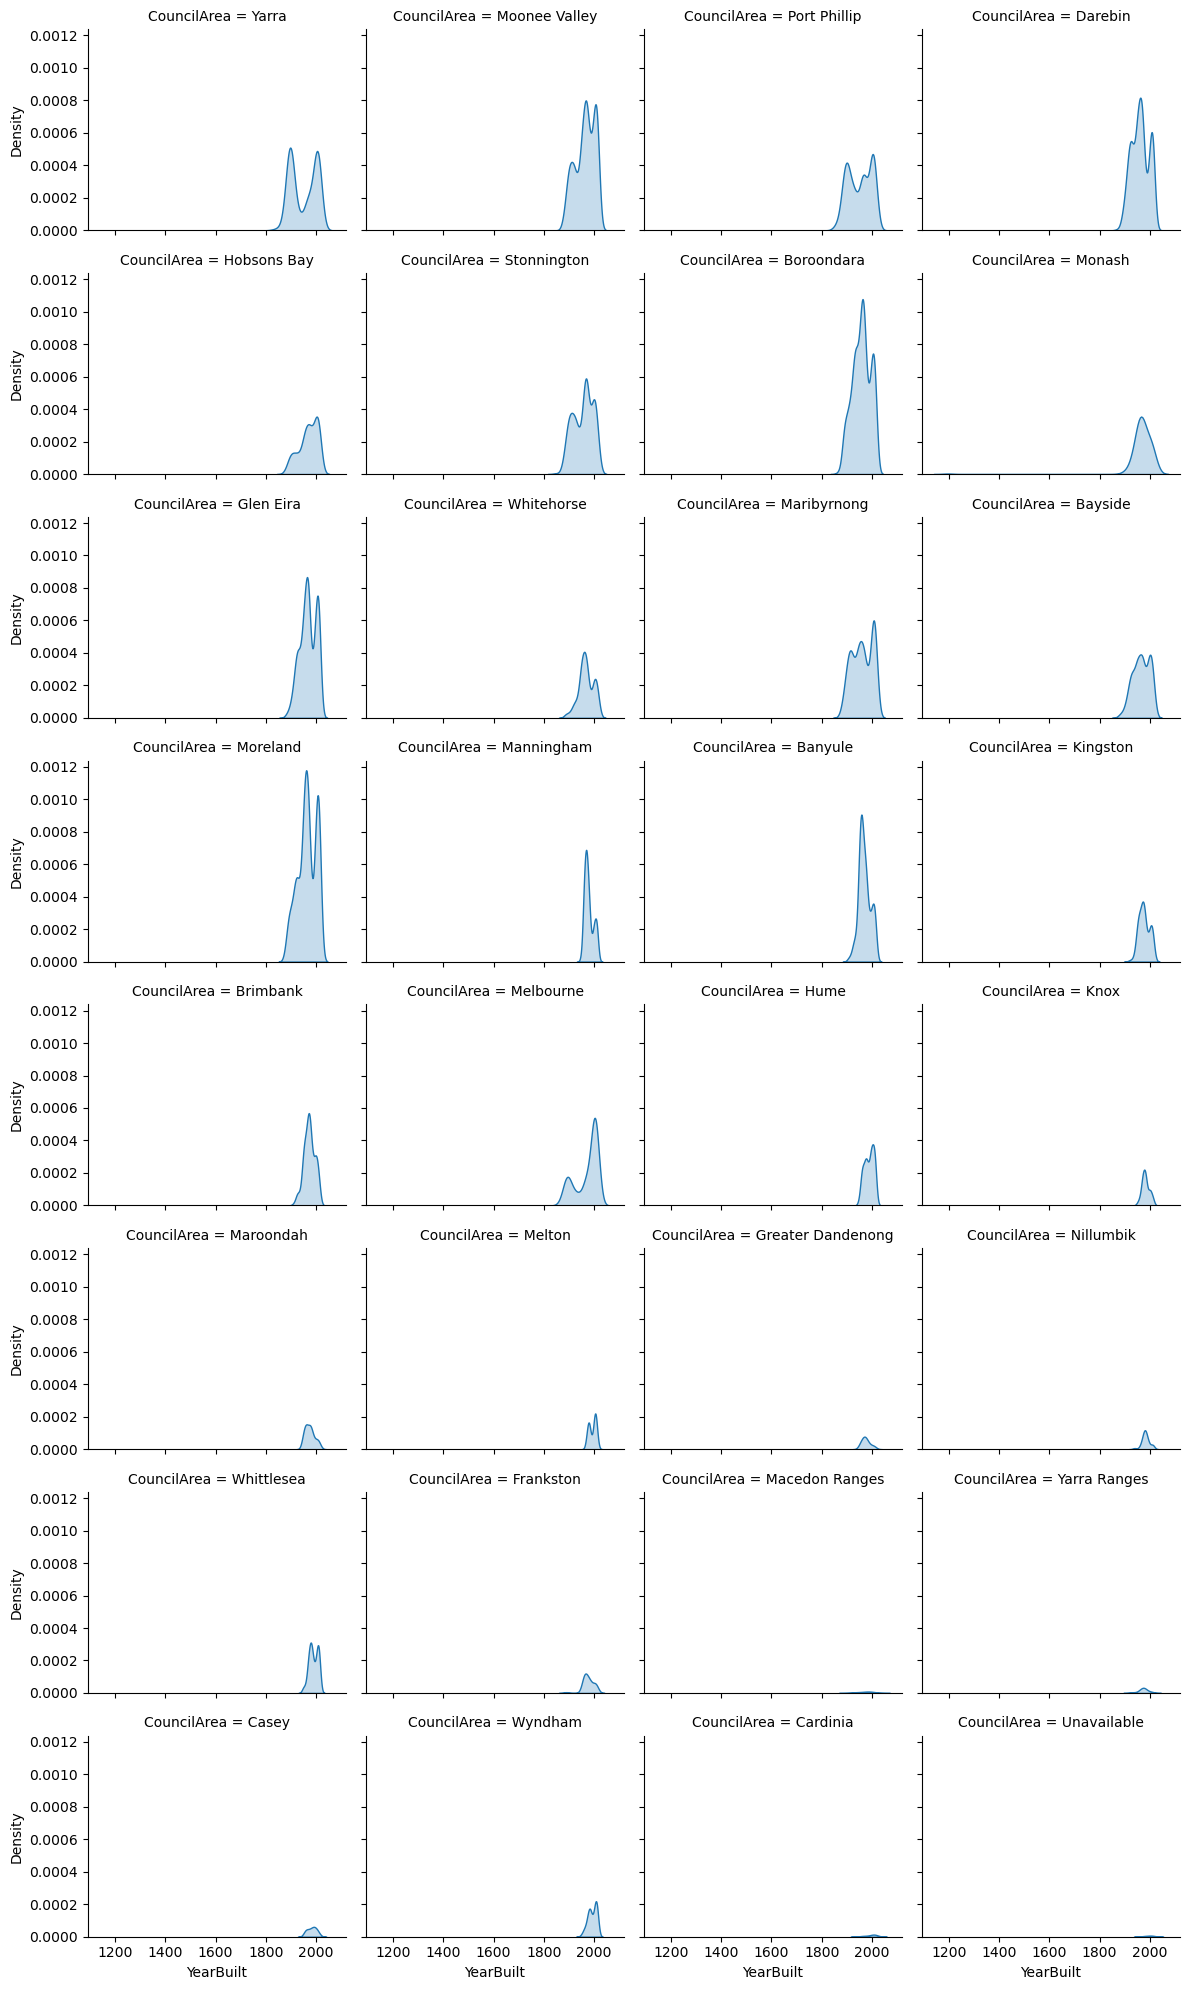

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

sns.displot(
    data=df_raw_logged.dropna(subset=["YearBuilt"]),
    x="YearBuilt",
    col="CouncilArea",
    col_wrap=4,
    kind="kde",
    fill=True,
    height=2.5,
    aspect=1.2
)

plt.tight_layout()
plt.show()


* Year Built is closely linked to the area the property is located in(Region and Council) since properties are likely to be constructed in phases. Hence, median imputation conditional on area is suitable. 
* Region is chosen rather than council as a feature for area for imputation since the proportion of missing Year Builds vary significantly by council (e.g. Moorabool which has no properties with Year Builds)
* The feature Missing_YearBuild is inlucded as a feature since there is variation of log(prices) based on if YearBuild is missing (missing years associated with higher property prices)

### EDA of features: Size features (Bathroom, Bedroom2, Building area, Car, Landsize, Rooms)

* All size features are likely to be correlated with an especially high correlation betwee: 
    * Bathroom, bedroom and rooms 
    * Building area and landsize 

### 

Text(0.5, 1.0, 'Spatial Distribution of House Prices')

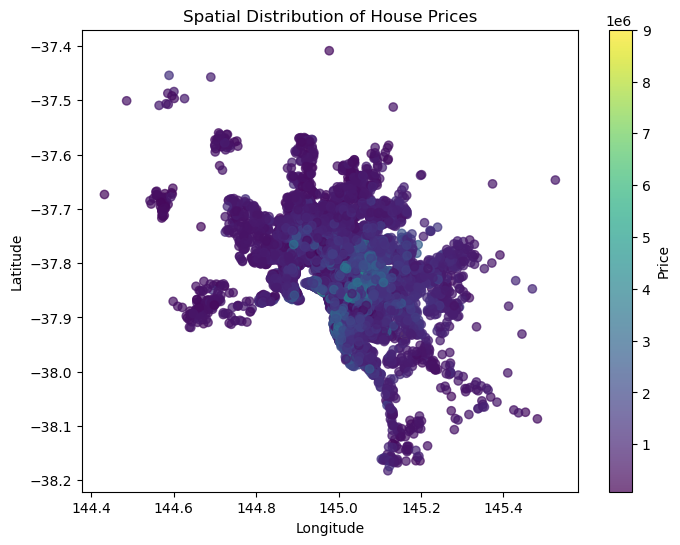

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(df_raw["Longtitude"], df_raw["Lattitude"], c=df_raw["Price"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of House Prices")


Text(0.5, 1.0, 'Price vs Latitude')

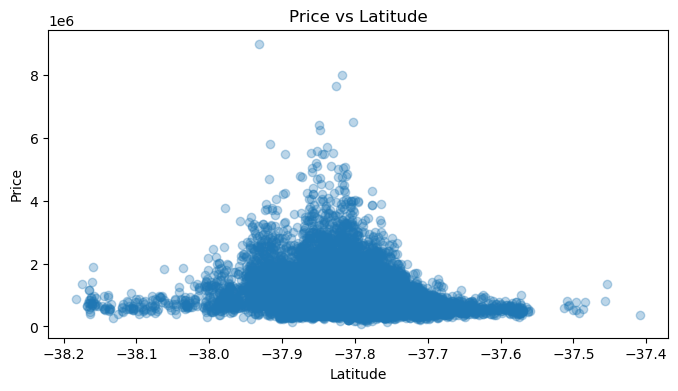

In [58]:
plt.figure(figsize=(8,4))
plt.scatter(df_raw["Lattitude"], df_raw["Price"], alpha=0.3)
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.title("Price vs Latitude")


Text(0.5, 1.0, 'Price vs Longitude')

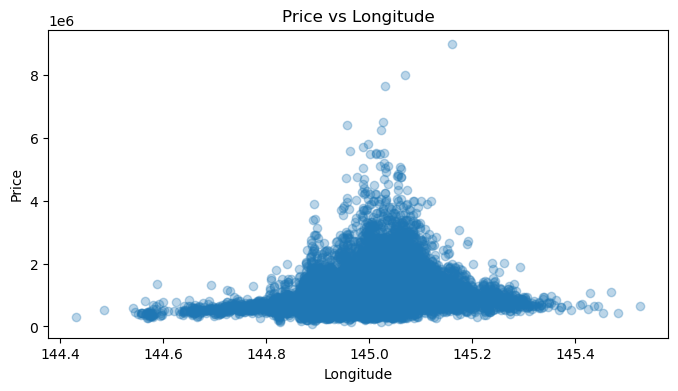

In [59]:
plt.figure(figsize=(8,4))
plt.scatter(df_raw["Longtitude"], df_raw["Price"], alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.title("Price vs Longitude")